<a href="https://colab.research.google.com/github/gsc16/MachineLearning/blob/master/hw3/hw3q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading data

When I have run the model with learning rate 0.00002 for 30 epochs, I could get a maximum validation accuracy of 89.60% and for 100 epochs, I could achieve 90.20%. With no shear, validation accuracy dropped drastically to a maximum of 60.02%. Finally, I have run the model with learning rate 0.00005 and I could achieve a maximum validation accuracy of 90.70%, after running for 100 epochs.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-14 21:16:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  76.4MB/s    in 0.9s    

2019-04-14 21:16:37 (76.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Extracting images and splitting data into training and test data sets

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Building the model with VGG19 convolutional base

#### Loading VGG19 convolutional base and freezing it

In [4]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step


#### Adding densely connected layers to the convolutional base

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# no dropout
model.add(layers.Dense(1, activation='sigmoid'))

### Training the model

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator( 
    rescale=1./255, 
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=0.00005), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50,
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 34s 338ms/step - loss: 0.5225 - acc: 0.7320 - val_loss: 0.3670 - val_acc: 0.8430
Epoch 2/100
100/100 [==============================] - 29s 291ms/step - loss: 0.3831 - acc: 0.8270 - val_loss: 0.3241 - val_acc: 0.8690
Epoch 3/100
100/100 [==============================] - 29s 289ms/step - loss: 0.3511 - acc: 0.8390 - val_loss: 0.3115 - val_acc: 0.8800
Epoch 4/100
100/100 [==============================] - 28s 275ms/step - loss: 0.3241 - acc: 0.8600 - val_loss: 0.3092 - val_acc: 0.8790
Epoch 5/100
100/100 [==============================] - 27s 273ms/step - loss: 0.3066 - acc: 0.8695 - val_loss: 0.2634 - val_acc: 0.8870
Epoch 6/100
100/100 [==============================] - 27s 269ms/step - loss: 0.2897 - acc: 0.8760 - val_loss: 0.2787 - val_acc: 0.8850
Epoch 7/100
100/100 [==============================]

### Displaying loss and accuracy during training

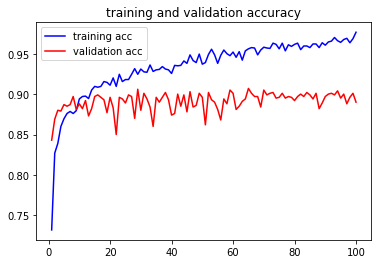

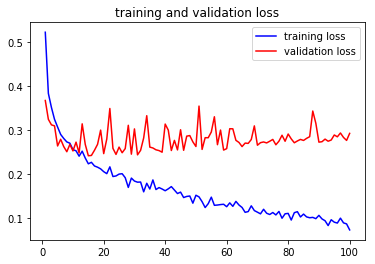

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'b', label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

### Displaying loss and accuracy during training with smaller learning rate

In [8]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.2971610951330513
Validation accuracy: 0.890999995470047
